In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [3]:
import tensorflow as tf

tf.__version__

'2.6.0'

In [4]:
print('GPU Information -', tf.test.gpu_device_name(), '\n')

!nvidia-smi

GPU Information - /device:GPU:0 

Mon Oct 11 06:51:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    70W / 149W |    121MiB / 11441MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                      

In [5]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!ls -l '/content/drive/MyDrive/Colab Notebooks/datasets'

total 2216991
-rw------- 1 root root   69155672 Sep 15 01:08 creditCardFraud.zip
-rw------- 1 root root     158636 Oct 11 05:24 daily_cost_quantity.csv
-rw------- 1 root root   16460562 Oct 11 00:31 daily_onion_wholesale.csv
-rw------- 1 root root   90618980 Sep 15 01:08 dogs_and_cats_small.zip
-rw------- 1 root root  862182613 Sep 15 01:08 GloVe.zip
-rw------- 1 root root   80596565 Sep 15 01:08 ko_w2v.zip
-rw------- 1 root root    7903524 Sep 15 01:08 naverRatings.zip
-rw------- 1 root root      33399 Sep  8 09:33 sample_submission.csv
-rw------- 1 root root     798145 Sep 26 15:28 test_0926.csv
-rw------- 1 root root     826548 Sep 26 15:28 train_0926.csv
-rw------- 1 root root 1141460846 Sep 15 01:08 waferImages.zip


# len(train)=2000, len(test)=398, lookback=90

In [7]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/daily_cost_quantity.csv',encoding = 'cp949')

In [8]:
df

,Unnamed: 0,date,qty,total,cost
0,17,2014-01-03,991.010,725.48,732.061230
1,19,2014-01-04,533.110,399.97,750.257921
2,20,2014-01-06,981.930,699.03,711.893923
3,21,2014-01-07,662.890,481.38,726.183831
4,22,2014-01-08,649.530,451.31,694.825489
...,...,...,...,...,...
2393,2193,2021-10-02,1171.170,945.29,807.133038
2394,2194,2021-10-04,1681.530,1400.94,833.134110
2395,2195,2021-10-05,1499.685,1276.92,851.458806
2396,2196,2021-10-06,1555.345,1380.85,887.809457


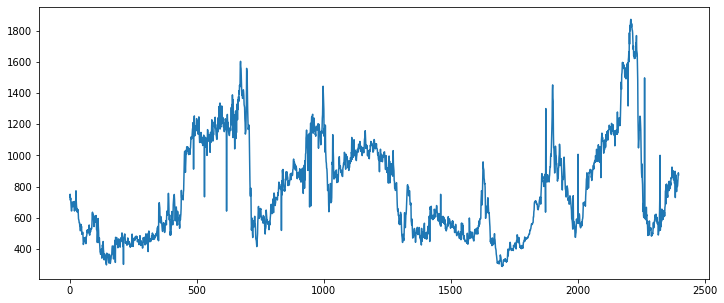

In [9]:
temp=df[['cost']]

plt.figure(figsize = (12, 5))
plt.plot(temp)
plt.show()

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))

temp = scaler.fit_transform(temp)

In [12]:
len(temp)

2398

In [11]:
train=temp[:2000]
test=temp[2000:]

In [12]:
train

array([[0.28066444],
       [0.2921443 ],
       [0.26794135],
       ...,
       [0.17501806],
       [0.17956418],
       [0.18575749]])

In [13]:
def create_dataset(time_data, look_back = 1):
    data_X, data_y = [],[]

    for i in range(len(time_data) - look_back):
        data_X.append(time_data[i:(i + look_back),0])
        data_y.append(time_data[i + look_back, 0])

    return np.array(data_X), np.array(data_y)

In [14]:
look_back = 90

train_X, train_y = create_dataset(train, look_back)
test_X, test_y = create_dataset(test, look_back)

In [15]:
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1],1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((1910, 90, 1), (1910,), (308, 90, 1), (308,))

In [16]:
model = Sequential(name = 'LSTM')
model.add(LSTM(64,
               input_shape = (None, 1)))
model.add(Dense(1, activation = 'tanh'))

In [17]:
model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(loss='mean_squared_error',
              optimizer = 'adam')

In [19]:
%%time

hist = model.fit(train_X, train_y,
                 epochs = 200,
                 batch_size = 16,
                 validation_data = (test_X, test_y))

Epoch 1/200
120/120 [==============================] - 10s 25ms/step - loss: 0.0094 - val_loss: 0.0072
Epoch 2/200
120/120 [==============================] - 2s 20ms/step - loss: 0.0024 - val_loss: 0.0062
Epoch 3/200
120/120 [==============================] - 2s 20ms/step - loss: 0.0022 - val_loss: 0.0063
Epoch 4/200
120/120 [==============================] - 2s 20ms/step - loss: 0.0019 - val_loss: 0.0054
Epoch 5/200
120/120 [==============================] - 2s 20ms/step - loss: 0.0018 - val_loss: 0.0064
Epoch 6/200
120/120 [==============================] - 2s 20ms/step - loss: 0.0017 - val_loss: 0.0050
Epoch 7/200
120/120 [==============================] - 2s 20ms/step - loss: 0.0017 - val_loss: 0.0075
Epoch 8/200
120/120 [==============================] - 2s 20ms/step - loss: 0.0016 - val_loss: 0.0047
Epoch 9/200
120/120 [==============================] - 2s 21ms/step - loss: 0.0015 - val_loss: 0.0048
Epoch 10/200
120/120 [==============================] - 2s 20ms/step - loss: 0.00

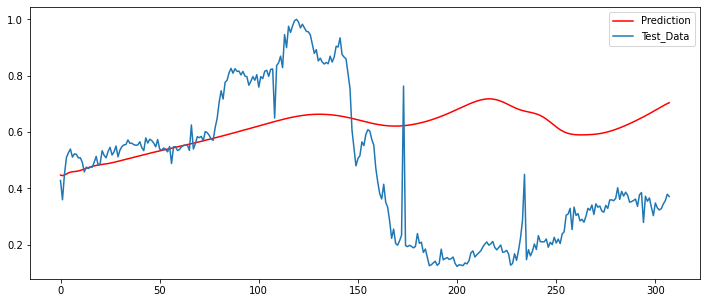

In [25]:
look_ahead = 308

xhat = test_X[0]

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size = 1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])

plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead), predictions, 'r', label = 'Prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label = 'Test_Data')
plt.legend()
plt.show()

# len(train)=2000, len(test)=398, lookback=90



In [80]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/daily_cost_quantity.csv',encoding = 'cp949')
temp=df[['cost']]

In [81]:
temp=np.array(temp)

In [82]:
train=temp[:2000]
test=temp[2000:]

In [83]:
look_back = 90

train_X, train_y = create_dataset(train, look_back)
test_X, test_y = create_dataset(test, look_back)

In [84]:
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1],1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((1910, 90, 1), (1910,), (308, 90, 1), (308,))

In [85]:
model2 = Sequential(name = 'LSTM2')
model2.add(LSTM(64,
               input_shape = (None, 1)))
model2.add(Dense(1, activation = 'tanh'))

In [86]:
model2.summary()

Model: "LSTM2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [87]:
model2.compile(loss='mean_absolute_error',
              optimizer = 'adam')

In [88]:
%%time

hist = model2.fit(train_X, train_y,
                 epochs = 200,
                 batch_size = 16,
                 validation_data = (test_X, test_y))

Epoch 1/200
120/120 [==============================] - 5s 24ms/step - loss: 745.3354 - val_loss: 1029.7092
Epoch 2/200
120/120 [==============================] - 2s 20ms/step - loss: 745.0298 - val_loss: 1029.7079
Epoch 3/200
120/120 [==============================] - 2s 20ms/step - loss: 745.0289 - val_loss: 1029.7073
Epoch 4/200
120/120 [==============================] - 2s 20ms/step - loss: 745.0286 - val_loss: 1029.7070
Epoch 5/200
120/120 [==============================] - 2s 20ms/step - loss: 745.0281 - val_loss: 1029.7068
Epoch 6/200
120/120 [==============================] - 2s 20ms/step - loss: 745.0283 - val_loss: 1029.7067
Epoch 7/200
120/120 [==============================] - 2s 20ms/step - loss: 745.0283 - val_loss: 1029.7067
Epoch 8/200
120/120 [==============================] - 2s 20ms/step - loss: 745.0280 - val_loss: 1029.7065
Epoch 9/200
120/120 [==============================] - 2s 20ms/step - loss: 745.0281 - val_loss: 1029.7064
Epoch 10/200
120/120 [===============

KeyboardInterrupt: ignored

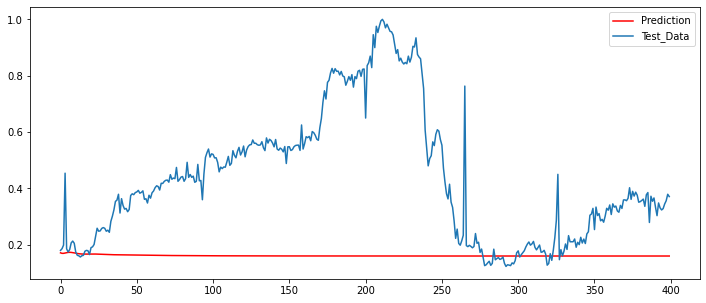

In [48]:
look_ahead = 400

xhat = test_X[0]

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size = 1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])

plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead), predictions, 'r', label = 'Prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label = 'Test_Data')
plt.legend()
plt.show()

#The End#